## Load Packages

In [2]:
import pandas as pd                       
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import matplotlib.pyplot as plt
from pycaret.regression import *

In [3]:
# user-defined functions, which can be put into a standalone module. I put it here for the purpose of ease
def standardize_dtype(df, numerical_cols, categorical_cols):
    df = df.copy()
    for col in categorical_cols:
        df[col] = df[col].astype("category")
    for col in numerical_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def plot_pie_chart(df, col, colors=None):
    counts = df[col].value_counts(sort=True)
    labels = counts.index
    values = counts.values
    pie = go.Pie(labels=labels, values=values, marker=dict(colors=colors))
    layout = go.Layout(title=f"{col} Distribution")
    fig = go.Figure(data=[pie], layout=layout)
    iplot(fig)

def plot_pie_chart_by_grp(df, x, y, tags):
    assert len(tags)>=2, "please ensure there are at least two categories in x"
    n_tag = len(tags)
    fig = make_subplots(rows=1, cols=len(tags), specs=[[{'type':'domain'}]*n_tag])
    annotation_lst = []
    annotation_pos = np.linspace(0.2, 0.8, n_tag) if n_tag>2 else [0.2, 0.8]

    for idx, (key, val) in enumerate(tags.items()):
        counts = df[df[x]==key][y].value_counts()
        fig.add_trace(go.Pie(labels=counts.index, values=counts.values, name=val), 1, idx+1)
        annotation_lst.append(dict(text=val, x=annotation_pos[idx], y=0.5, font_size=20, showarrow=False))

    # Use `hole` to create a donut-like pie chart
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")

    fig.update_layout(
        title_text=f"Pie Chart of '{y}' by '{x}'",
        # Add annotations in the center of the donut pies.
        annotations=annotation_lst
    )
    fig.show()
    
def hist_by_grp(df,x, y, color, barmode="group", histfunc="avg", **kwargs):
    fig = px.histogram(df, x=x, y=y, color=color, barmode=barmode, histfunc=histfunc, **kwargs)
    fig.show()

def plot_bubble_charts(df, group, x, y, aggfunc="mean", cnt_col="ID"):
    tmp = df.groupby([group])[x,y].agg(aggfunc).dropna()
    df1 = pd.DataFrame(tmp).reset_index()
    tmp = df.groupby([group])[cnt_col].count()
    df2 = pd.DataFrame(tmp).reset_index()
    dataset = df1.merge(df2)

    scatterplots = list()
    for grp in dataset[group]:
        df = dataset[dataset[group]==grp]
        trace = go.Scatter(
            x = df[x],
            y = df[y],
            name = str(grp),
            marker=dict(
                symbol='circle',
                sizemode='area',
                sizeref=0.05,
                size=df[cnt_col])
        )
        scatterplots.append(trace)
                            
    layout = go.Layout(title=f'Mean {x} and {y} by {group}', 
                    xaxis=dict(title=x), 
                    yaxis=dict(title=y),
                    showlegend=True)

    fig = dict(data = scatterplots, layout = layout)
    iplot(fig)

def scatterplot(df, x, y, title):
    fig = px.scatter(df, x=x, y=y, marginal_x="histogram", marginal_y="histogram")
    fig.update_layout(title=title)
    fig.show()

## Read Data

In [4]:
df_profile = pd.read_csv("../data/profiles.csv", index_col=0)
df_risk = pd.read_csv("../data/risk.csv", index_col=0).reset_index(drop=True)

## EDA

In [5]:
df_profile.head()

,ID,Sex,Age,Smoking,BMI,Heart rate data used,MET (activity level)
0,1,F,44.6671223513329,no,20.136249,1.0,16.812778
1,2,F,37.2221462747779,no,28.731747,1.0,11.625394
2,3,M,38.4634313055366,no,22.129740,1.0,32.309224
3,4,F,25.3315105946685,yes,22.939751,0.0,12.570449
4,5,F,37.1018455228982,former,28.507522,0.0,30.080823


In [6]:
df_profile.shape

(233, 7)

In [12]:
df_profile.describe(include='all') # below suggests data error in `Age` column

,ID,Sex,Age,Smoking,BMI,Heart rate data used,MET (activity level)
count,233.000000,233,233,233,233.000000,233.000000,233.000000
unique,NaN,2,230,3,NaN,NaN,NaN
top,NaN,F,45.7853725222146,no,NaN,NaN,NaN
freq,NaN,128,2,152,NaN,NaN,NaN
mean,117.000000,NaN,NaN,NaN,27.057882,0.626609,17.247569
std,67.405489,NaN,NaN,NaN,16.843256,0.484746,18.175526
min,1.000000,NaN,NaN,NaN,3.596908,0.000000,0.145333
25%,59.000000,NaN,NaN,NaN,22.913774,0.000000,5.404917
50%,117.000000,NaN,NaN,NaN,24.913495,1.000000,11.886912
75%,175.000000,NaN,NaN,NaN,28.507522,1.000000,22.805854


In [9]:
df_profile.dtypes

ID                        int64
Sex                      object
Age                      object
Smoking                  object
BMI                     float64
Heart rate data used    float64
MET (activity level)    float64
dtype: object

In [10]:
cate_cols = ["Sex","Smoking","Heart rate data used"]
num_cols = ["Age", "BMI", "MET (activity level)"]
df_profile_clean = standardize_dtype(df_profile, num_cols, cate_cols)

In [11]:
df_profile_clean.dtypes

ID                         int64
Sex                     category
Age                      float64
Smoking                 category
BMI                      float64
Heart rate data used    category
MET (activity level)     float64
dtype: object

In [14]:
df_profile_clean.describe(include='all').to_clipboard() # below suggests data error in `Age` column

### Check NaN

In [10]:
df_profile_clean.isna().sum()

ID                      0
Sex                     0
Age                     2
Smoking                 0
BMI                     0
Heart rate data used    0
MET (activity level)    0
dtype: int64

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">ID 152 and 193 have data errors in Age values</span>

In [11]:
df_profile[df_profile_clean["Age"].isna()]

,ID,Sex,Age,Smoking,BMI,Heart rate data used,MET (activity level)
151,152,M,"58,8899521531101",no,21.499597,1.0,70.449079
192,193,M,"32,6288448393712",no,22.994615,1.0,13.280556


In [12]:
df_profile_clean.describe(include='all') # below suggests data error in `Age` column

,ID,Sex,Age,Smoking,BMI,Heart rate data used,MET (activity level)
count,233.000000,233,231.000000,233,233.000000,233.0,233.000000
unique,NaN,2,NaN,3,NaN,2.0,NaN
top,NaN,F,NaN,no,NaN,1.0,NaN
freq,NaN,128,NaN,152,NaN,146.0,NaN
mean,117.000000,NaN,39.998284,NaN,27.057882,NaN,17.247569
std,67.405489,NaN,9.489209,NaN,16.843256,NaN,18.175526
min,1.000000,NaN,22.999316,NaN,3.596908,NaN,0.145333
25%,59.000000,NaN,32.072454,NaN,22.913774,NaN,5.404917
50%,117.000000,NaN,39.491456,NaN,24.913495,NaN,11.886912
75%,175.000000,NaN,47.429938,NaN,28.507522,NaN,22.805854


In [13]:
df_profile_clean["age_group"] = pd.cut(df_profile_clean["Age"], bins=[1,20,35,50,100], precision=0)
df_profile_clean["age_qgroup"] = pd.qcut(df_profile_clean["Age"], q=10, precision=0)

In [14]:
df_profile_clean.head()

,ID,Sex,Age,Smoking,BMI,Heart rate data used,MET (activity level),age_group,age_qgroup
0,1,F,44.667122,no,20.136249,1.0,16.812778,"(35, 50]","(43.0, 46.0]"
1,2,F,37.222146,no,28.731747,1.0,11.625394,"(35, 50]","(37.0, 39.0]"
2,3,M,38.463431,no,22.129740,1.0,32.309224,"(35, 50]","(37.0, 39.0]"
3,4,F,25.331511,yes,22.939751,0.0,12.570449,"(20, 35]","(22.0, 28.0]"
4,5,F,37.101846,former,28.507522,0.0,30.080823,"(35, 50]","(37.0, 39.0]"


In [15]:
print("Age Stats by Sex:")
display(df_profile_clean.groupby("Sex")[["Age"]].describe())
hist_data = df_profile_clean[["Sex","Age"]].pivot(columns="Sex", values="Age")
fig = ff.create_distplot([hist_data["M"].dropna(),hist_data["F"].dropna()], ['M','F'])
fig.update_layout(title="Density plot of Age by Sex")
fig.show()

Age Stats by Sex:


Age                                                                    \
     count       mean        std        min        25%        50%        75%   
Sex                                                                            
F    128.0  38.791802   8.848808  22.999316  31.745044  38.086124  45.766917   
M    103.0  41.497601  10.072402  24.453862  33.086808  42.375940  49.197539   

                
           max  
Sex             
F    57.987697  
M    60.645249

In [16]:
hist_by_grp(df_profile_clean, x="Age", y="BMI", color="Sex", barmode="group", marginal="box", histfunc="count", title="Barplot of Sample Count by Sex and Binned Age")

In [17]:
print("BMI Stats by Sex:")
display(df_profile_clean.groupby("Sex")[["BMI"]].describe())
hist_by_grp(df_profile_clean, x="Age", y="BMI", color="Sex", barmode="group", histfunc="avg", title="Barplot of Average BMI by Sex and Binned Age")

BMI Stats by Sex:


BMI                                                                    \
     count       mean        std        min        25%        50%        75%   
Sex                                                                            
F    128.0  25.416325   5.776370   3.596908  21.933366  24.094344  28.385384   
M    105.0  29.059017  24.181676  17.226562  23.529412  25.912132  28.719723   

                 
            max  
Sex              
F     42.201019  
M    270.416441

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">Potentially an outlier in BMI values of male samples, investigating it further</span>

In [18]:
scatterplot(df_profile_clean, x="Age", y="BMI", title = "Scatter plot of Age v.s. BMI")
print("Outlier confirmed and imputed by its quantile age bucket's average")
display(df_profile_clean.query("BMI>200"))
print("After imputation:")

Outlier confirmed and imputed by its quantile age bucket's average


,ID,Sex,Age,Smoking,BMI,Heart rate data used,MET (activity level),age_group,age_qgroup
200,201,M,53.820916,former,270.416441,0.0,2.134192,"(50, 100]","(53.0, 61.0]"


After imputation:


<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">Use Age group's mean BMI to impute BMI for ID 201</span>

In [19]:
cond = "Age>53.5 and Sex=='M' and ID!=201"
df_profile_clean.loc[df_profile_clean["ID"]==201,"BMI"] = df_profile_clean.query(cond)["BMI"].mean()

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">Use BMI group's mean age to impute ages for ID 152 and 193 with wrong ages</span>

In [20]:
df_profile_clean["bmi_qgroup"] = pd.qcut(df_profile_clean["BMI"], q=10, precision=2)

cond = "BMI>20.45 and BMI<=22.31"
df_profile_clean.loc[df_profile_clean["ID"]==152, "Age"] =  df_profile_clean.query(cond)["Age"].mean()
cond = "BMI>22.31 and BMI<=23.3"
df_profile_clean.loc[df_profile_clean["ID"]==193, "Age"] =  df_profile_clean.query(cond)["Age"].mean()

In [21]:
print("Re-do BMI Stats by Sex:")
display(df_profile_clean.groupby("Sex")[["BMI"]].describe())
hist_by_grp(df_profile_clean, x="Age", y="BMI", color="Sex", barmode="group", histfunc="avg", title="Barplot of Average BMI by Sex and Binned Age")
fig = px.scatter(df_profile_clean, x="Age", y="BMI", marginal_x="histogram", marginal_y="histogram")
fig.update_layout(title="Scatter plot of Age v.s. BMI")
fig.show()

Re-do BMI Stats by Sex:


BMI                                                                   \
     count       mean       std        min        25%        50%        75%   
Sex                                                                           
F    128.0  25.416325  5.776370   3.596908  21.933366  24.094344  28.385384   
M    105.0  26.738040  4.386196  17.226562  23.529412  25.912132  28.405504   

                
           max  
Sex             
F    42.201019  
M    41.030173

In [22]:
# re-apply age groups after imputation
df_profile_clean["age_group"] = pd.cut(df_profile_clean["Age"], bins=[1,20,35,50,100], precision=0)
df_profile_clean["age_qgroup"] = pd.qcut(df_profile_clean["Age"], q=10, precision=0)

In [23]:
scatterplot(df_profile_clean, x="Age", y="MET (activity level)", title = "Scatter plot of Age v.s. MET")

print("MET Stats by Sex:")
display(df_profile_clean.groupby("Sex")[["MET (activity level)"]].describe())
hist_by_grp(df_profile_clean, x="Age", y="MET (activity level)", color="Sex", barmode="group", histfunc="avg", title="Barplot of Average MET by Sex and Binned Age")

MET Stats by Sex:


MET (activity level)                                                      \
                   count      mean        std       min       25%        50%   
Sex                                                                            
F                  128.0  14.39453  14.988698  0.517505  5.312286  10.090285   
M                  105.0  20.72556  20.984693  0.145333  6.243507  13.280556   

                            
           75%         max  
Sex                         
F    19.740776  117.923590  
M    26.599167   85.775515

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">MET data is skewed right</span>

### Sex

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">approximiately balanced sample in Sex with slightly more female proportion</span>

In [24]:
my_colors = ['#f4cb42', '#a1a8b5'] #gold, silver
plot_pie_chart(df_profile_clean, col="Sex", colors=my_colors)

### Smoking

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">The majority are non-smokers; ~27% are former smokers</span>

In [25]:
plot_pie_chart(df_profile_clean, col="Smoking")

### Heart Rate Data Availability

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">The majority submitted heart rate data</span>

In [26]:
plot_pie_chart(df_profile_clean, col="Heart rate data used", colors=my_colors)

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">Compared to Female samples, males' average BMIs are higher regardless of smoker status</span>

In [27]:
hist_by_grp(df_profile_clean, x="Sex", y="BMI", color="Smoking")

In [28]:
hist_by_grp(df_profile_clean, x="Sex", y="MET (activity level)", color="Smoking")
print(f"Sample size of Male & Smoking out of {len(df_profile_clean)}:", df_profile_clean.query("Sex=='M' and Smoking=='yes'").shape[0])

Sample size of Male & Smoking out of 233: 8


In [29]:
x = "Sex"
y = "Smoking"
tags = {'M':"Male",'F':"Female"}
plot_pie_chart_by_grp(df_profile_clean,x,y,tags)

In [30]:
px.histogram(df_profile_clean, x="Sex",y="BMI",color="Smoking", barmode="group", histfunc="count")

In [31]:
group = "age_group"
x = "BMI"
y = "MET (activity level)"
plot_bubble_charts(df_profile_clean, group=group, x=x, y=y, aggfunc="mean")

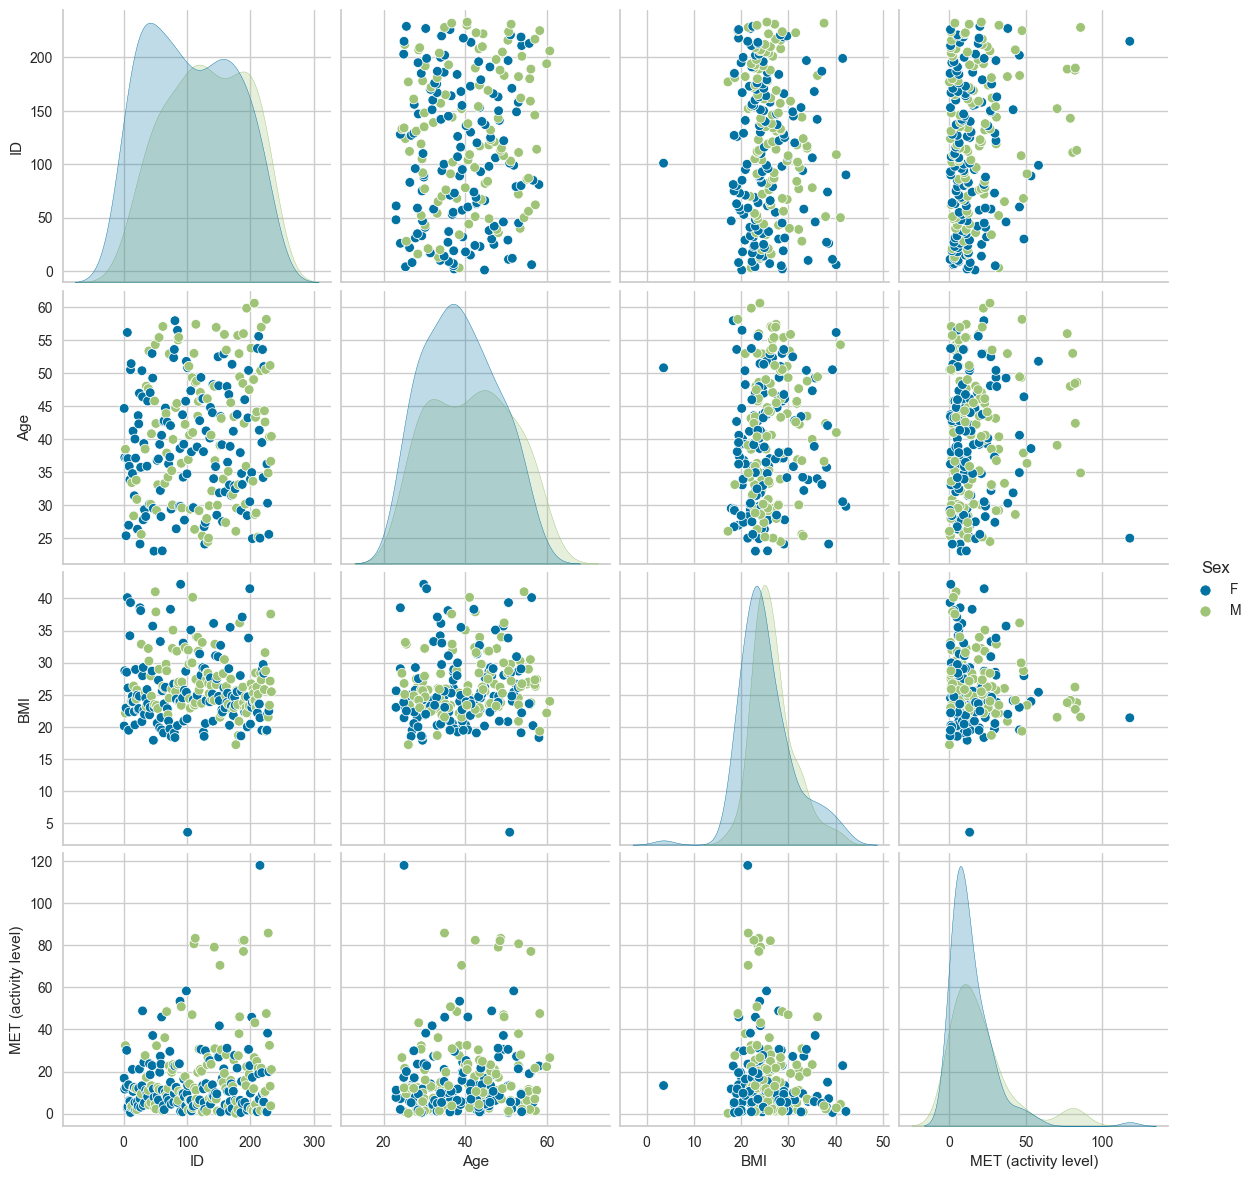

In [32]:
sns.pairplot(df_profile_clean, hue="Sex", height=3, diag_kind="kde")
plt.show()

### More EDA on Cancer Risk and prepare final dataset for modeling in the next section

In [33]:
df_profile_clean.shape

(233, 10)

In [34]:
df_profile_clean.columns

Index(['ID', 'Sex', 'Age', 'Smoking', 'BMI', 'Heart rate data used',
       'MET (activity level)', 'age_group', 'age_qgroup', 'bmi_qgroup'],
      dtype='object')

Now we prepare dataset related to cancer risk and we take into account that only individuals with a risk greater than zero for a particular disease are included in the risk column. Given the description of the task, we sum of the risks related to cancer for each individual and hence, in the subsequent modeling stage, the problem is a regression task.

In [35]:
df_risk["Diseases"] = df_risk["Diseases"].str.lower()
df_risk["have_cancer_risk"] = df_risk.Diseases.str.contains('cancer')
df_cancer = df_risk.groupby(["ID", "have_cancer_risk"])[["risk"]].sum().reset_index().query("have_cancer_risk==True").drop(columns=["have_cancer_risk"])

In [36]:
df_profile_clean.isna().sum()

ID                      0
Sex                     0
Age                     0
Smoking                 0
BMI                     0
Heart rate data used    0
MET (activity level)    0
age_group               0
age_qgroup              0
bmi_qgroup              0
dtype: int64

In [37]:
df_cancer.isna().sum()

ID      0
risk    0
dtype: int64

In [38]:
df = df_profile_clean.merge(df_cancer, on="ID", how="left")
df["risk"] = df["risk"].fillna(0)

Question: What group of people look like they might be at a higher risk of getting cancer?

- Assumption: general risk factors for cancer include but not limited to older age, history of cancer, using tobacco, obesity, alcohol, radiation, etc.
    - We suppose that high age, high BMI, Smoking and low MEI would increase cancer risk

- Looking at the rightmost column, we see
    - an inverse relationship between risk and MEI level
    - a positive yet not strong linear relation between risk and BMI, between risk and Age
    - from the right tail of the density plots, the sample indicates a higher risk in female samples, likely due to the higher risk in the senior age bucket.

In [39]:
df.describe()

,ID,Age,BMI,MET (activity level),risk
count,233.000000,233.000000,233.000000,233.000000,233.000000
mean,117.000000,39.976638,26.011948,17.247569,0.532762
std,67.405489,9.452255,5.227222,18.175526,0.389341
min,1.000000,22.999316,3.596908,0.145333,0.000000
25%,59.000000,32.142174,22.913774,5.404917,0.282500
50%,117.000000,39.335612,24.913495,11.886912,0.458200
75%,175.000000,47.346548,28.405504,22.805854,0.753700
max,233.000000,60.645249,42.201019,117.923590,2.439100


In [40]:
df.dtypes

ID                         int64
Sex                     category
Age                      float64
Smoking                 category
BMI                      float64
Heart rate data used    category
MET (activity level)     float64
age_group               category
age_qgroup              category
bmi_qgroup              category
risk                     float64
dtype: object

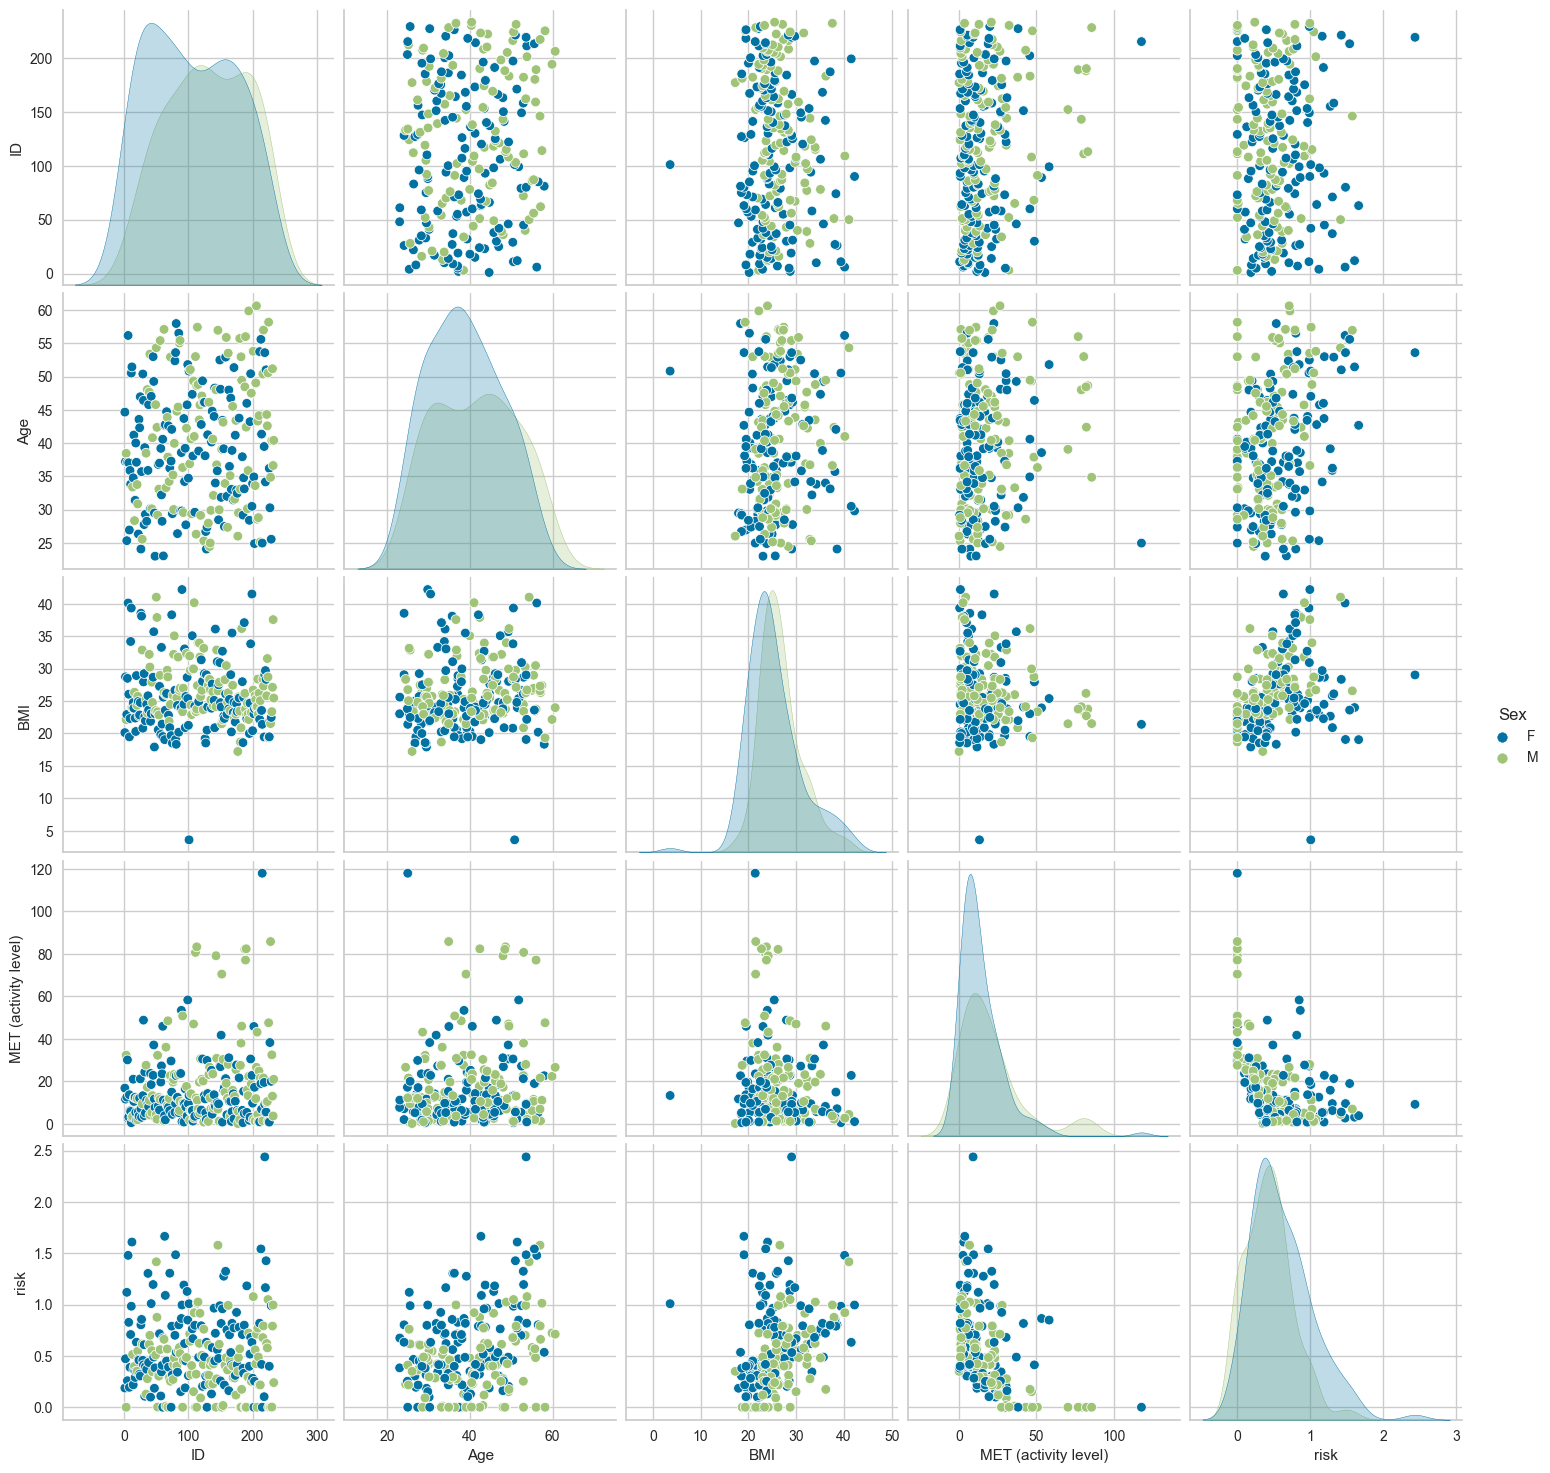

In [41]:
sns.pairplot(df, hue="Sex", height=3, diag_kind="kde")
plt.show()

All EDA below substantiate the conjecture above. Also, we see:
- Smoking increase cancer risk
- No obvious impact from submission of heart rate data, as expected

In [42]:
# numerical features
## scatter plot Age v.s. Risk
scatterplot(df, x="Age", y="risk",title="Scatter plot of Age v.s. Cancer Risk")
## scatter plot Age v.s. Risk
scatterplot(df, x="BMI", y="risk",title="Scatter plot of BMI v.s. Cancer Risk")
## scatter plot Age v.s. Risk
scatterplot(df, x="MET (activity level)", y="risk",title="Scatter plot of MET v.s. Cancer Risk")

# categorical features
## box plot sex v.s. risk
fig = px.box(df, x="Sex", y="risk", title="Box Plot: Sex v.s. Risk")
fig.show()
## box plot sex v.s. risk
fig = px.box(df, x="Smoking", y="risk", title="Box Plot: Smoking v.s. Risk")
fig.show()
## box plot sex v.s. risk
fig = px.box(df, x="Heart rate data used", y="risk", title="Box Plot: Heart Rate Data v.s. Risk")
fig.show()

# Othres: bar plot Age v.s. Risk per Sex 
print("Risk by Sex:")
display(df.groupby("Sex")[["risk"]].describe())
hist_by_grp(df, x="Age", y="risk", color="Sex", barmode="group", histfunc="avg", title="Barplot of Average Cancer Risk by Sex and Binned Age")
hist_by_grp(df, x="BMI", y="risk", color="Sex", barmode="group", histfunc="avg", title="Barplot of Average Cancer Risk by Sex and Binned BMI")

Risk by Sex:


risk                                                          
     count      mean       std  min      25%     50%     75%     max
Sex                                                                 
F    128.0  0.614475  0.419527  0.0  0.31305  0.4889  0.8176  2.4391
M    105.0  0.433150  0.324023  0.0  0.22370  0.4161  0.6127  1.5787

## Modeling
Let us use PyCaret for quick exploration

In [1]:
#from pycaret.regression import *

In [44]:
cate_cols

['Sex', 'Smoking', 'Heart rate data used']

In [45]:
target = "risk"
cols_to_use = num_cols + cate_cols + [target]
df_model = df[cols_to_use].copy()

In [46]:
# check stats
df_model.describe()

,Age,BMI,MET (activity level),risk
count,233.000000,233.000000,233.000000,233.000000
mean,39.976638,26.011948,17.247569,0.532762
std,9.452255,5.227222,18.175526,0.389341
min,22.999316,3.596908,0.145333,0.000000
25%,32.142174,22.913774,5.404917,0.282500
50%,39.335612,24.913495,11.886912,0.458200
75%,47.346548,28.405504,22.805854,0.753700
max,60.645249,42.201019,117.923590,2.439100


In [47]:
# #uncomment for testing purpose
# data = df_model.sample(frac=0.9, random_state=124)
# data_unseen = df_model.drop(data.index)

# data.reset_index(drop=True, inplace=True)
# data_unseen.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(data.shape))
# print('Unseen Data For Predictions ' + str(data_unseen.shape))
data = df_model
print('Data for Modeling: ' + str(data.shape))

Data for Modeling: (233, 7)


In [48]:
reg_benchmark = setup(data = data, target = target, numeric_features=num_cols,categorical_features=cate_cols, train_size=0.8, session_id=12) #adjust train size due to small dataset

,Description,Value
0,session_id,12
1,Target,risk
2,Original Data,"(233, 7)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(186, 8)"


In [49]:
best_benchmark = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0684,0.0174,0.1179,0.8932,0.0676,0.5611,0.0320
catboost,CatBoost Regressor,0.0697,0.0207,0.1213,0.8894,0.0669,0.3554,0.2040
gbr,Gradient Boosting Regressor,0.0890,0.0193,0.1336,0.8588,0.0772,0.3801,0.0080
rf,Random Forest Regressor,0.0949,0.0267,0.1520,0.8205,0.0879,0.3656,0.0380
lightgbm,Light Gradient Boosting Machine,0.1054,0.0276,0.1551,0.8097,0.0887,0.4756,0.0120
xgboost,Extreme Gradient Boosting,0.1016,0.0307,0.1646,0.7881,0.0944,0.2743,0.0220
ada,AdaBoost Regressor,0.1430,0.0367,0.1828,0.7269,0.1162,1.4699,0.0130
ridge,Ridge Regression,0.1542,0.0449,0.2045,0.6722,0.1296,1.1900,0.0040
br,Bayesian Ridge,0.1544,0.0452,0.2049,0.6713,0.1298,1.1882,0.0040
lr,Linear Regression,0.1545,0.0450,0.2051,0.6688,0.1302,1.1928,0.5940


### Add Feature Engineering
- we add normalization, transformation, remove multicollinearity, feature interaction and feature_ratio. We attempted to apply `bin_numeric_features` to `MET` given there are very few extreme values outside the expected range, yet it did not help increase the CV score.

In [50]:
reg = setup(data = data, target = target, numeric_features=num_cols, categorical_features=cate_cols, train_size=0.8,
            normalize = True, transformation = True, remove_multicollinearity = True, multicollinearity_threshold = 0.9,
            feature_interaction=True, feature_ratio=True, session_id=12)

,Description,Value
0,session_id,12
1,Target,risk
2,Original Data,"(233, 7)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(186, 11)"


In [51]:
top3 = compare_models(exclude = ['ransac'], n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0697,0.0199,0.1187,0.8915,0.0663,0.4076,0.3320
gbr,Gradient Boosting Regressor,0.0820,0.0187,0.1268,0.8720,0.0733,0.2761,0.0170
et,Extra Trees Regressor,0.0741,0.0203,0.1305,0.8662,0.0770,0.6025,0.0440
lightgbm,Light Gradient Boosting Machine,0.1050,0.0284,0.1569,0.8043,0.0901,0.5546,0.0120
rf,Random Forest Regressor,0.0986,0.0307,0.1608,0.7920,0.0952,0.4653,0.0560
xgboost,Extreme Gradient Boosting,0.0956,0.0298,0.1608,0.7713,0.0955,0.3002,0.0170
br,Bayesian Ridge,0.1397,0.0423,0.1947,0.7038,0.1167,0.8699,0.0040
ridge,Ridge Regression,0.1396,0.0422,0.1945,0.7038,0.1166,0.8723,0.0060
ada,AdaBoost Regressor,0.1432,0.0390,0.1902,0.7023,0.1210,1.6879,0.0180
lr,Linear Regression,0.1403,0.0425,0.1957,0.6982,0.1173,0.8758,0.0060


### Create a model

In [52]:
cbt = create_model('catboost', fold = 10, round = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.05,0.00,0.07,0.95,0.04,0.98
1,0.14,0.11,0.33,0.68,0.13,0.15
2,0.06,0.01,0.10,0.94,0.06,0.09
3,0.05,0.01,0.07,0.95,0.05,0.72
4,0.04,0.00,0.05,0.96,0.04,0.13
5,0.06,0.01,0.09,0.91,0.07,0.09
6,0.11,0.02,0.15,0.83,0.10,1.56
7,0.05,0.01,0.09,0.95,0.05,0.10
8,0.08,0.02,0.13,0.83,0.08,0.13


### Hyperparameter tuning
Here I chose brute force random grid search instead of optimiziation approach due to small dataset and decent performane without tuning

In [53]:
tuned_cbt = tune_model(cbt, n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0593,0.0070,0.0836,0.9233,0.0479,0.6150
1,0.1286,0.0635,0.2519,0.8163,0.0994,0.2159
2,0.0744,0.0118,0.1088,0.9237,0.0640,0.1247
3,0.0592,0.0067,0.0817,0.9392,0.0576,0.7231
4,0.0475,0.0038,0.0618,0.9437,0.0474,0.1464
5,0.0628,0.0070,0.0839,0.9221,0.0617,0.1513
6,0.0946,0.0226,0.1505,0.8319,0.0923,0.7463
7,0.0671,0.0074,0.0859,0.9524,0.0547,0.1738
8,0.0908,0.0147,0.1214,0.8588,0.0725,0.1743


In [54]:
plot_model(tuned_cbt, plot = 'parameter')

,Parameters
nan_mode,Min
eval_metric,RMSE
iterations,190
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


### Stacking
We used stacking as one example to show the usage of ensembling. Below we spot a even better metric from the stacker. Given that extremely high model performance is not the only objective of this task and interpretability of model also matters to the stakeholders. I decide to use the tuned Catboost regressor.

In [55]:
lr = create_model('lr')
stacker = stack_models([tuned_cbt]+top3[1:], meta_model = lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0634,0.0069,0.0828,0.9247,0.0495,2.5440
1,0.1044,0.0421,0.2052,0.8782,0.0787,0.1894
2,0.0896,0.0164,0.1279,0.8947,0.0659,0.1328
3,0.0454,0.0036,0.0603,0.9668,0.0362,0.2459
4,0.0784,0.0110,0.1051,0.8369,0.0817,0.2452
5,0.0660,0.0066,0.0814,0.9267,0.0598,0.1505
6,0.0875,0.0134,0.1156,0.9008,0.0758,2.0531
7,0.0634,0.0073,0.0857,0.9526,0.0521,0.1556
8,0.0898,0.0140,0.1182,0.8660,0.0690,0.1587


### Model Interpretability

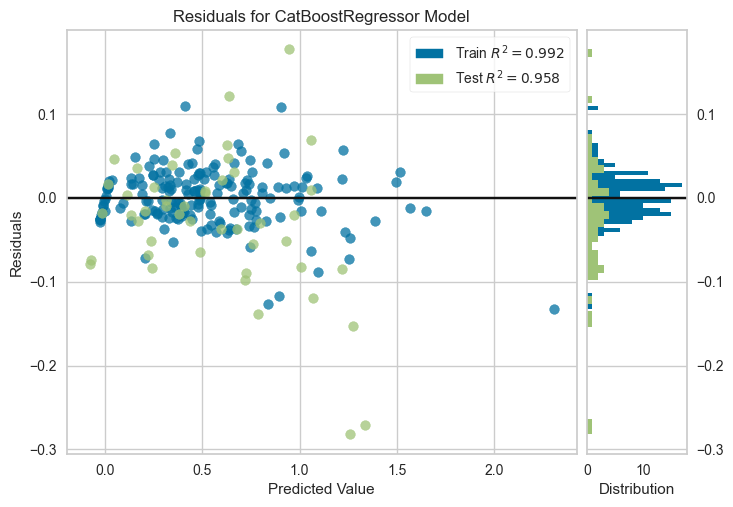

In [56]:
plot_model(tuned_cbt)

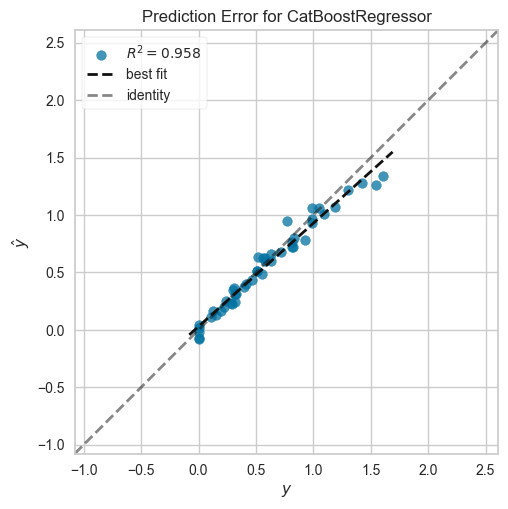

In [57]:
plot_model(tuned_cbt, plot = 'error')

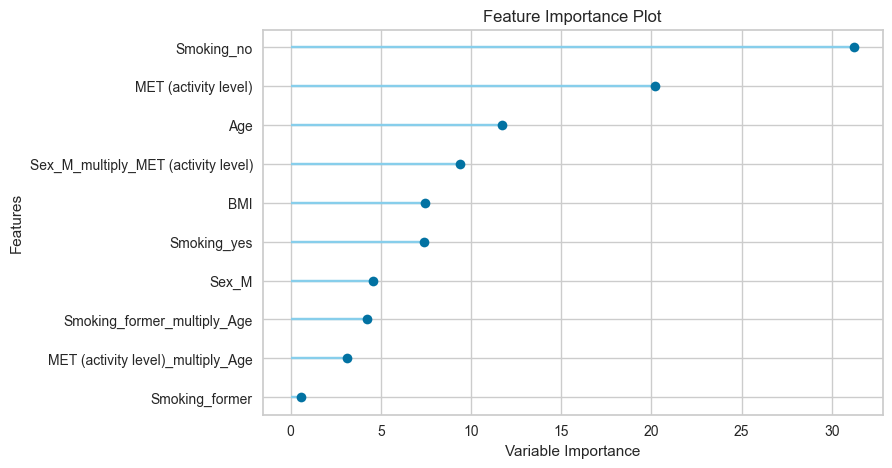

In [58]:
plot_model(tuned_cbt, plot='feature')

Note: the model also learns that whether an individual submit his/her heart data would not impact cancer risk

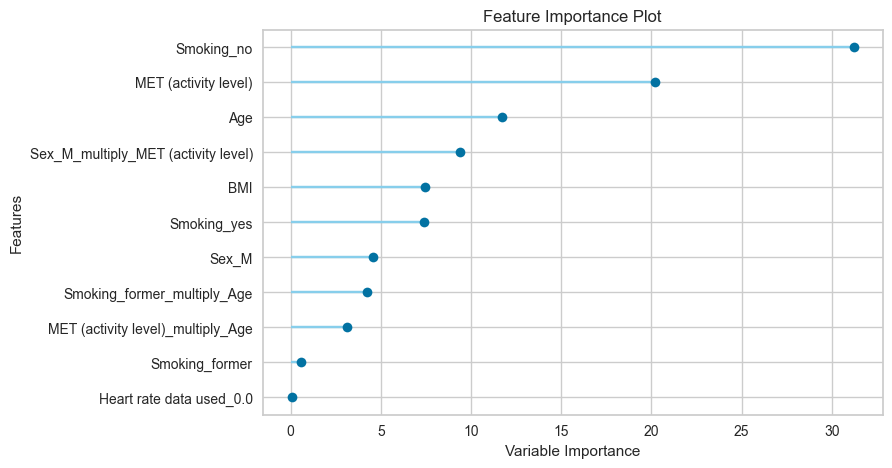

In [59]:
plot_model(tuned_cbt, plot='feature_all')

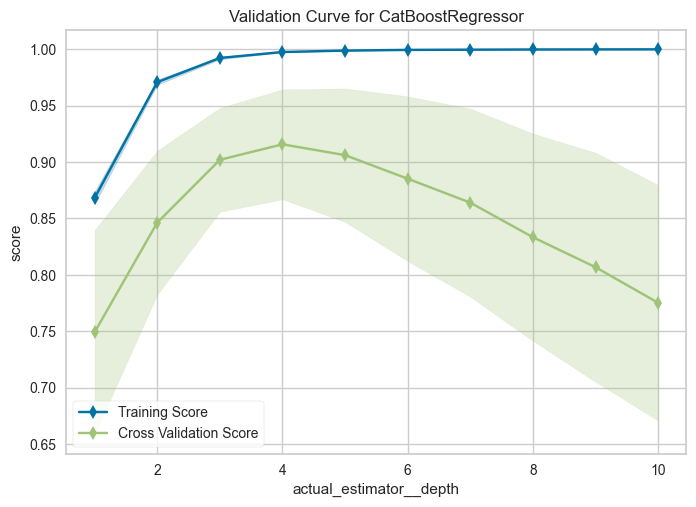

In [60]:
plot_model(tuned_cbt, plot='vc')

depth got cut at 4 to prevent overfitting

In [61]:
tuned_cbt.get_params()

{'depth': 3,
 'l2_leaf_reg': 5,
 'loss_function': 'RMSE',
 'border_count': 254,
 'verbose': False,
 'random_strength': 0.7,
 'task_type': 'CPU',
 'n_estimators': 190,
 'random_state': 12,
 'eta': 0.15}

### Finalize Model (fitting on all dataset except for the unseen one)

In [62]:
final_cbt = finalize_model(tuned_cbt)

In [72]:
# # Check predictions on unseen data (for testing purpose only) 
# unseen_predictions = predict_model(final_cbt, data=data_unseen)
# unseen_predictions.head()

### Save model

In [65]:
save_model(final_cbt,'../model/Final CatBoost Regressor 101122')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Sex', 'Smoking',
                                                             'Heart rate data '
                                                             'used'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['Age', 'BMI',
                                                           'MET (activity '
                                                           'level)'],
                                       target='risk', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fi...
                                        correlation_with_target_threshold=0.0,
                                        target_vari

### Load saved model before deployment

In [66]:
saved_mod = load_model('../model/Final CatBoost Regressor 101122')

Transformation Pipeline and Model Successfully Loaded


In [67]:
prediction = predict_model(saved_mod, data=data)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0283,0.0015,0.0385,0.9902,0.0244,0.2074


In [68]:
prediction["Label"] = [i if i>0 else 0 for i in prediction["Label"]]

In [69]:
prediction.head()

,Age,BMI,MET (activity level),Sex,Smoking,Heart rate data used,risk,Label
0,44.667122,20.136249,16.812778,F,no,1.0,0.1869,0.262049
1,37.222146,28.731747,11.625394,F,no,1.0,0.4718,0.457073
2,38.463431,22.129740,32.309224,M,no,1.0,0.0000,0.000000
3,25.331511,22.939751,12.570449,F,yes,0.0,1.1196,1.039459
4,37.101846,28.507522,30.080823,F,former,0.0,0.2582,0.395223


___